In [1]:
# Recommendation: logging config like this, otherwise you'll be flooded with unnecessary information
import logging
logging.basicConfig(level=logging.ERROR)

<span style="color:darkred;font-weight:bold;font-size:2em">If you're unfamiliar with Jupyter Notebooks but still want to use this CREST Demo,<br /> then it is easiest to select `Cell` -> `Run all` from the menu above. All code will be executed for you!</span>

## Import the CREST model and the CREST simulator libraries

In [2]:
# import all modeling concepts
from crestdsl.model import *

# import the simulator
from crestdsl.simulation import Simulator

## Define the resources that we use in the system

In this system we will deal with positions, velocity and acceleration.  
Additionally the system can define the mass of objects (in kg).  
The restitution factor, although not being a resource in the literal sense, is also defined as a resource.

In [3]:
m = Resource("m", REAL)                 # meters (position)
mps = Resource("m/s", REAL)             # meters per second (velocity)
mps2 = Resource("m/s/s", REAL)          # meters per second per second (acceleration)
kg = Resource("kg", REAL)               # kilograms
restitution = Resource("factor", REAL)  # the restitution factor 

"""
These are model parameters. They can be used to set initial conditions and similar.
Remember to only use variables as initial values for ports or e.g. in __init__ functions.
Never use them in transition guards, updates, actions or influences, since the simulator cannot predict their value and hence cannot calculate the correct next transition time.
"""

# These variables are used as default values for ports
global e 
e = 0.9  # restitution factor
L = 7  # table length
H = 3  # table height


## Definition of the Mass entity

In [4]:
class Mass(Entity):
    """
    A simple mass entity. It is placed at a certain (x,y) position with a specific velocity (vx, vy) 
    and acceleration (ax, ay). The x-velocity can be set using an input vx_in. If vx_in != 0 it will 
    override the value currently held by the entity. It offers its x and vx values in the ports x_out
    and vx_out.
    
    If the mass reaches the end of the table (x == L) the entity switches to the falling-state and 
    modifies its y-acceleration and hence also its y-position. From that moment it becomes similar 
    to a bouncing-ball experiment, except that it's x-value also changes. On every bounce, the 
    restitution factor slows the velocity of both x and y by the restitution factor.
    """
    
    
    """- - - - - - - - - Constructor - - - - - - - - -"""
    
    def __init__(self, x0, vx0=0):
        """We have to provide an initial x-position on the table and an initial x-velocity"""
        self.x.value = x0
        self.vx.value = vx0
    
    """- - - - - - - - - PORTS - - - - - - - - -"""

    e = Local(restitution, e)  # restitution factor
    L = Local(m, L)  # table length
    H = Local(m, H)  # table height
    
    x = Local(m, 0)  # the position (init should be an input param)
    y = Local(m, 3)  # the height of the table (should be an input param)
    
    x_out = Output(m, 0)  # forward output
    vx_out = Output(mps, 0) # forward output
    vx_in = Input(mps, 0) # to set the speed from the outside
    
    vx = Local(mps, 3)  # this should be an input param
    vy = Local(mps, 0)  # this should be an input param
    
    ay = Local(mps2, 0)  # acceleration

    """- - - - - - - - - INFLUENCES - - - - - - - - -"""
        
    forward_x_out = Influence(source=x, target=x_out)
    forward_vx_out = Influence(source=vx, target=vx_out)

    """- - - - - - - - - STATES - - - - - - - - -"""
    
    on_table = current = State()
    falling = State()  # downward movement
    bouncing = State() # upward movement
       
    """- - - - - - - - - TRANSITIONS - - - - - - - - -"""    
    
    fall_off_table = Transition(source=on_table, target=falling, guard=(lambda self: self.x.value == self.L.value and self.vx.value > 0))
    
    # actually we should find when the vy == 0 for the guard.
    # However, Python's floats aren't as precise as Z3's Real datatype, so a == 0 can provide wrong results.
    # it's safer to use inequalities when comparing floats (duh...)
    fall   = Transition(source=bouncing, target=falling, guard=(lambda self: self.vy.value <= 0))
    
    # We should use an inequality here as well (y <= 0)
    # However, since our system is non-linear (the y position changes with dt^2), this means that the optimization is non-linear. And Z3 is just not good at that!
    # We therefore use the following trick: We try to find the place where the absolute value is very close to 0
    # Why don't you try setting it to 10 ** -10, and executing the simulation again?
    bounce = Transition(source=falling, target=bouncing, guard=(lambda self: abs(self.y.value) < 10**-3))  

    """- - - - - - - - - Actions & Updates - - - - - - - - -"""
    
    # bounce actions
    @action(transition=bounce, target=vx)
    def action_apply_vx_restitution(self):
        """on bounce we apply restitution to vx"""
        return self.vx.pre * self.e.value # apply restitution factor  

    @action(transition=bounce, target=vy)
    def action_vy_bouncing(self):
        """on bounce we apply restitution to vy and also inverse the force to change the direction """
        return self.vy.pre * self.e.value  * -1 # use restitution and inverse force
  
    # X value updates
    
    @update(state=[on_table, falling, bouncing], target=x)
    def update_x(self, dt):
        """ The X value is the previous x value + average velocity * dt"""
        return self.x.pre + (self.vx.value + self.vx.pre) / 2 * dt
    
    @update(state=[on_table, falling, bouncing], target=vx)
    def update_vx(self, dt):
        """ If we have an external value set to vx_in, then we use that one. If the external value is 0, then we continue using the internal value."""
        if self.vx_in.value != 0: # external setting of speed
            return self.vx_in.value
        else:
            return self.vx.pre

    # Y value updates
                      
    @update(state=[falling, bouncing], target=ay)
    def update_ay_falling(self, dt):
        """change the acceleration to the value of gravity (rounded)"""
        return -9.81
    
    @update(state=[falling, bouncing], target=y)
    def update_y(self, dt):
        """The new position is the old position plus average velocity times passed time"""
        average_velocity = (self.vy.value + self.vy.pre) / 2.0 
        return self.y.pre + average_velocity * dt  # traversed distance = (v0+v_end)/2*t 
    
    @update(state=[falling, bouncing], target=vy)
    def update_vy(self, dt):
        """The average velocity is the previous velocity plus acceleration times time.
        Note, that velocity here can be positive and negative, depending on whether we're falling or bouncing up again"""
        return self.vy.pre + self.ay.value * dt


mass = Mass(x0=0, vx0=3) # Create a mass with initial position zero (reminder: he table has a length of 7)
sim = Simulator(mass)    # create a simulator for the mass
sim.stabilise()          # stabilize the system (make sure the initial values are propagated and the x and vx-out values are set correctly)
sim.plot()               # we can plot the system here to see what it looks like

## Run Simulation (advance time)
Below is the code that simulates time advance.
Following that, we let *plotly* draw a graph. (Try analyzing it by zooming in and looking at the measurement points).


**The simulation breaks at some point shortly after 17 timeunits**

**Warning**  
Note, that the graph only shows the most current values at a timestamp. Therefore it looks like the y-velocity `vy` is always positive.
This is not correct!
The plots measurement points shown are the values *after* the transitions are fired (and the related actions override the values from before).

A CREST transition firing consists of the following steps:
 1. advance time, calculate the new port value  
 2. fire transition + execute transition actions
 3. stabilise and calculate new port values (execute updates with dt = 0)

After each one of these steps, the values are logged into a time-portvalue map. 
In the case of the `vy` port, this means that step 1 will calculate the velocity at transition from `falling` to `bouncing` (which will a negative value since it will be the fastest right at the time of bouncing off). As soon as the transition is fired, the action will calculate a new value for `vy`, without any time advancing. 
This means the new value of `vy` will replace the old `vy` value in the plot.

Although the plotted measurement points (the cross-markers) are correct values, the connection lines in the below plot are misleading.
We hope to improve the tracing and plotting capabilities.

**Debug Info:** If you only see a white box but no graph, try deactivating your adblocker. In some situations AdblockPlus and PrivacyBadger were preventing the required JavaScript from loading.

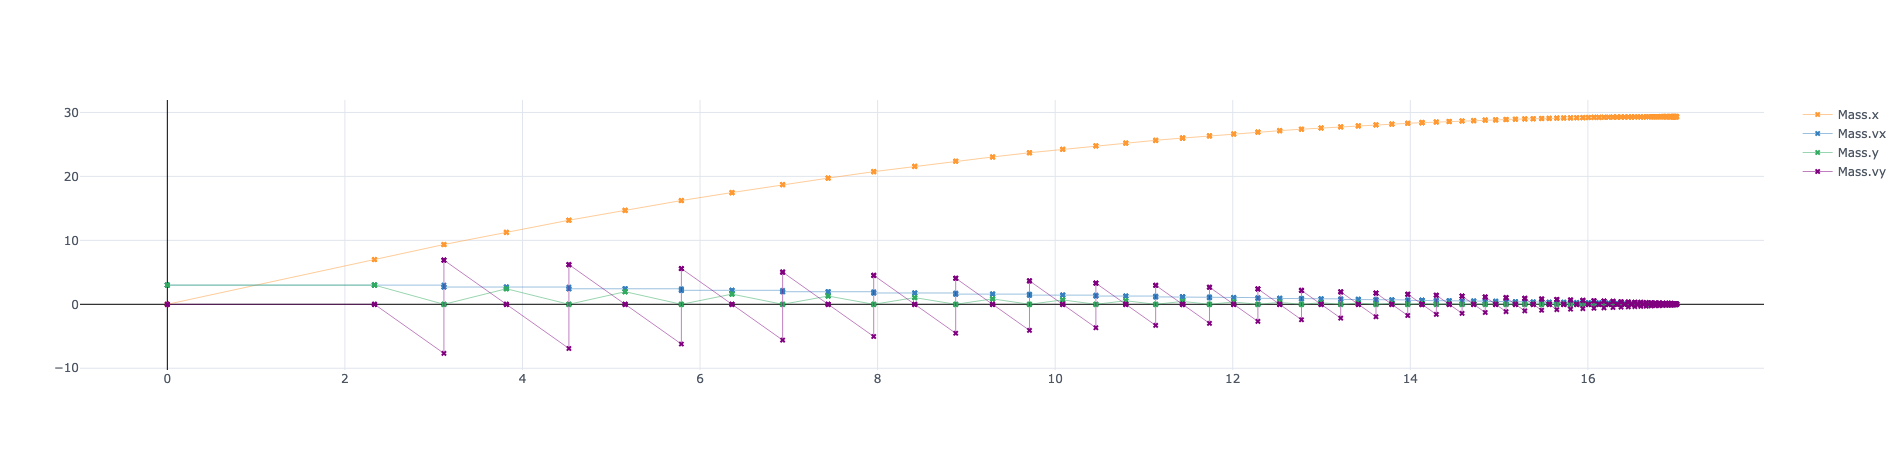

In [5]:
mass = Mass(x0=0, vx0=3)
mass_sim = Simulator(mass)
mass_sim.stabilise()        # stabilize the system (make sure the initial values are propagated and the x and vx-out values are set correctly)
mass_sim.advance(17)        # advance time     --- Note, advancing more than 17.186372009515782 will kill the Python kernel. Please don't do it! (Restart with Kernel -> Restart & Run All above if you already did )

mass_sim.traces.plot(traces=[mass.x, mass.vx, mass.y, mass.vy])

### Smaller time steps 
By default, the simulator advances in as big steps as possible. 
However, this means that we lose out on tracking values inbetween.
To counteract this behaviour we can force CREST to advance in slower time steps.
The plot below shows the tracking after executing 65 time steps of size 0.25 each.

Note, how despite the chosen time step, we se that at transition times additional values are logged, as above.
These are the points where behaviour changes and CREST is forced to stabilize the system.

One beneficial feature is that the plot below displays the actual behaviour of `vy` much better. 

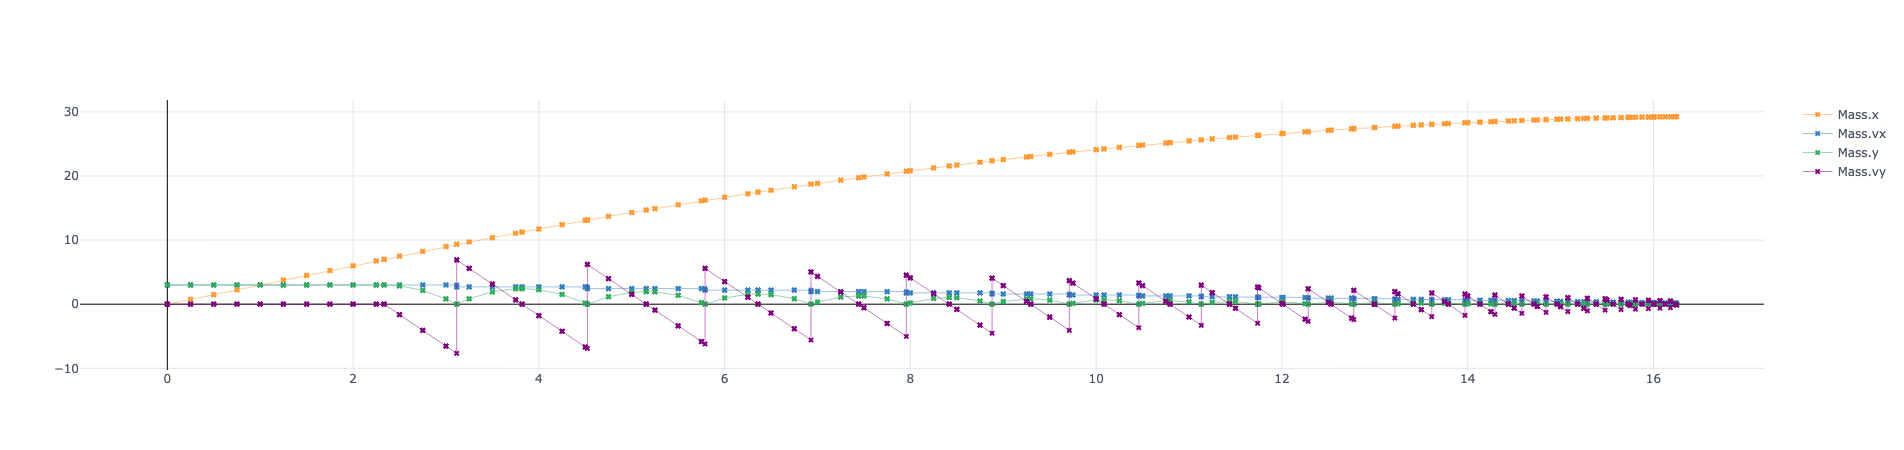

In [6]:
mass2 = Mass(x0=0, vx0=3)
smallstep_sim = Simulator(mass2)
smallstep_sim.stabilise()
[smallstep_sim.advance(.25) for _ in range(65)]
smallstep_sim.traces.plot(traces=[mass2.x, mass2.vx, mass2.y, mass2.vy])

## Three Masses system

In [7]:
class ThreeMasses(Entity):
    """
    The three masses system
    
    This system initializes three equal masses (their measured mass is defined in port m).
    There are three individual states: the masses do not touch, mass1 touches mass2 and mass2 touches mass3
    (In this model it is not possible for all masses to touch at the same time!)
    
    The transitions are based on the x-positions. If their distance is lower than a certain threshold and the
    first one is faster than the second one, we call it a collision. Then some actions will kick in and change
    the involved masses' velocities. (i.e. set them externally). If they don't touch, we use updates to continuously 
    set their vx_in to zero, so that the masses calculate vx themselves.
    """
    
    """- - - - - - - - - PORTS - - - - - - - - -"""
    
    e = Local(restitution, e)  # restitution factor
    m = Local(kg, 1)  # the actual mass of each object is 1 kg, we assume all masses are equal. Otherwise we need to adapt our system

    """- - - - - - - - - SUBENTITIES - - - - - - - - -"""
    
    mass1 = Mass(x0=0, vx0=3)     # mass1 is placed at 0 but has a velocity
    mass2 = Mass(x0=6.5)          # mass2 is placed at 6.5 (close to the end) but does not move
    mass3 = Mass(x0=7)            # mass3 is placed right at the edge (7), but does not fall because it's velocity is 0
    
    """- - - - - - - - - STATES - - - - - - - - -"""
    
    no_touch = current = State()  # no collisions
    m1_touch_m2 = State()         # when mass1 hits mass2
    m2_touch_m3 = State()         # when mass2 hits mass3
    
    """- - - - - - - - - TRANSITIONS - - - - - - - - -"""
    
    # same as above. the x_out values are based on non-linear constraints 
    collide_m1_m2     = Transition(source=no_touch, target=m1_touch_m2, guard=(lambda self: abs(self.mass1.x_out.value - self.mass2.x_out.value) < 0.1 * 10**-3 and self.mass1.vx_out.value > self.mass2.vx_out.value ))
    m1_m2_collision_to_no_touch = Transition(source=m1_touch_m2, target=no_touch, guard=(lambda self: abs(self.mass1.x_out.value - self.mass2.x_out.value) > 0.1 * 10**-3 and self.mass1.vx_out.value <= self.mass2.vx_out.value ))
    collide_m2_m3     = Transition(source=no_touch, target=m2_touch_m3, guard=(lambda self: abs(self.mass2.x_out.value - self.mass3.x_out.value) < 0.1 * 10**-5 and self.mass2.vx_out.value > self.mass3.vx_out.value ))
    m2_m3_collision_to_no_touch = Transition(source=m2_touch_m3, target=no_touch, guard=(lambda self: abs(self.mass2.x_out.value - self.mass3.x_out.value) > 0.1 * 10**-3 and self.mass2.vx_out.value <= self.mass3.vx_out.value ))

    """- - - - - - - - - UPDATES & ACTIONS - - - - - - - - -"""
    
    @update(state=no_touch, target=mass1.vx_in)
    def no_touch_mass1vx_in(self, dt):
        # if we the masses don't touch, then don't change their velocity
        return 0
    
    @update(state=no_touch, target=mass2.vx_in)
    def no_touch_mass2vx_in(self, dt):
        # if we the masses don't touch, then don't change their velocity
        return 0

    @update(state=no_touch, target=mass3.vx_in)
    def no_touch_mass3vx_in(self, dt):
        # if we the masses don't touch, then don't change their velocity
        return 0
    
    @action(transition=collide_m1_m2, target=mass1.vx_in)
    def m1_collide_m2_action_m1_vx(self):
        # on collision with mass2 change mass1's velocity
        m = self.m.value  # read the current port values into local variables
        e = self.e.value  # this makes the formula below easier to read
        return self.mass1.vx_out.value * (m - e * m) / (2 * m) + self.mass2.vx_out.value * m * (1 + e) / (2*m)
    
    @action(transition=collide_m1_m2, target=mass2.vx_in)
    def m1_collide_m2_action_m2_vx(self):
        # on collision with mass1 change mass2's velocity
        m = self.m.value
        e = self.e.value
        return self.mass1.vx_out.value * (1 + e) * m / (2*m) + self.mass2.vx_out.value * (m - e * m) / (2*m)
    
    @action(transition=collide_m2_m3, target=mass2.vx_in)
    def m2_collide_m3_action_m1_vx(self):
        # on collision with mass3 change mass2's velocity
        m = self.m.value
        e = self.e.value
        return self.mass2.vx_out.value * (m - e * m) / (2*m) + self.mass3.vx_out.value * m * (1 + e) / (2*m)
    
    @action(transition=collide_m2_m3, target=mass3.vx_in)
    def m2_collide_m3_action_m2_vx(self):
        # on collision with mass2 change mass3's velocity
        m = self.m.value
        e = self.e.value
        return self.mass2.vx_out.value * (1 + e) * m / (2*m) + self.mass3.vx_out.value * (m - e * m) / (2*m)
    

## Simulating the ThreeMasses
This might take a few seconds ( or a minute...)

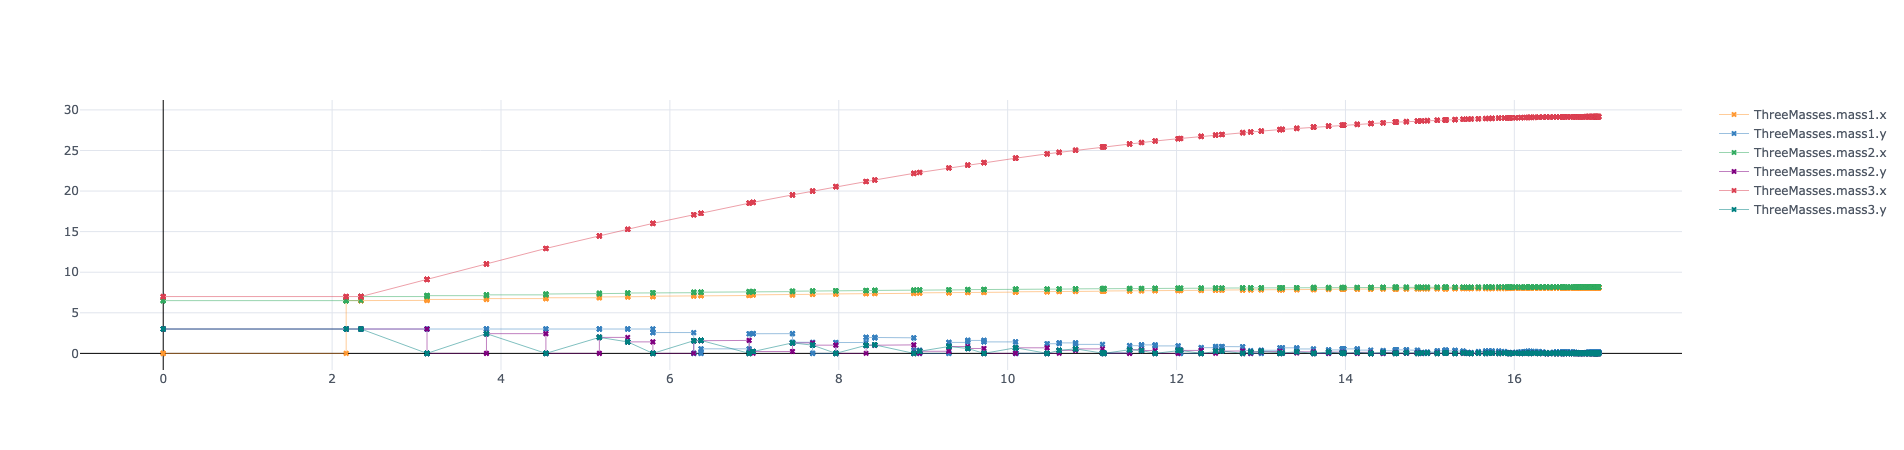

In [8]:
# Initialize the simulator, run it and plot the data 
# in the plot we can see nicely how one mass touches the other (follow the masses' x-values)
    
three_masses = ThreeMasses()       # create three masses system
three_sim = Simulator(three_masses)# create simulator
three_sim.stabilise()              # stabilize the system (make sure the initial values are propagated and the x and vx-out values are set correctly)
three_sim.advance(17)              # advance time  (the simulation would break shortly after 17 timeunits, hence 17 is enough for us)

three_sim.traces.plot(traces=[three_masses.mass1.x, three_masses.mass1.y,three_masses.mass2.x, three_masses.mass2.y,three_masses.mass3.x, three_masses.mass3.y])